#Decision Trees

## Scratch implementation

### Read data from a CSV file & get it ready to use

---



In [14]:
import pandas as pd
import numpy as np
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OrdinalEncoder, LabelEncoder

# Read CSV file
df = pd.read_csv("playtennis.csv")
print(df.head(5))
print('-----')

# Define feature and target columns
X_df = df.iloc[:, :-1]
y_df = df.iloc[:, -1]

print(X_df.head(5))
print(y_df.head(5))
print('-----')

# Define categories for ordinal encoding
categories = [
    ["Sunny", "Overcast", "Rain"],        # Outlook: 0=Sunny, 1=Overcast, 2=Rain
    ["Hot", "Mild", "Cool"],              # Temperature: 0=Hot, 1=Mild, 2=Cool
    ["High", "Normal"],                   # Humidity: 0=High, 1=Normal
    ["Weak", "Strong"]                    # Wind: 0=Weak, 1=Strong
]

# Create and apply column transformer
feature_encoder = ColumnTransformer(
    transformers=[
        ('categorical', OrdinalEncoder(categories=categories), list(range(X_df.shape[1])))
    ]
)
X = feature_encoder.fit_transform(X_df)

# Encode target labels
label_encoder = LabelEncoder()
label_encoder.classes_ = np.array(["No", "Yes"])
y = label_encoder.transform(y_df)

# X and y now contain your encoded data
print("X =", X.tolist())
print("y =", y.tolist())


  Outlook Temperature Humidity    Wind PlayTennis
0   Sunny         Hot     High    Weak         No
1   Sunny         Hot     High  Strong         No
2   Sunny         Hot   Normal    Weak        Yes
3   Sunny         Hot   Normal  Strong        Yes
4   Sunny        Mild     High    Weak        Yes
-----
  Outlook Temperature Humidity    Wind
0   Sunny         Hot     High    Weak
1   Sunny         Hot     High  Strong
2   Sunny         Hot   Normal    Weak
3   Sunny         Hot   Normal  Strong
4   Sunny        Mild     High    Weak
0     No
1     No
2    Yes
3    Yes
4    Yes
Name: PlayTennis, dtype: object
-----
X = [[0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 1.0], [0.0, 0.0, 1.0, 0.0], [0.0, 0.0, 1.0, 1.0], [0.0, 1.0, 0.0, 0.0], [0.0, 1.0, 0.0, 1.0], [0.0, 1.0, 1.0, 0.0], [0.0, 1.0, 1.0, 1.0], [0.0, 2.0, 0.0, 0.0], [0.0, 2.0, 0.0, 1.0], [0.0, 2.0, 1.0, 0.0], [0.0, 2.0, 1.0, 1.0], [1.0, 0.0, 0.0, 0.0], [1.0, 0.0, 0.0, 1.0], [1.0, 0.0, 1.0, 0.0], [1.0, 0.0, 1.0, 1.0], [1.0, 1.0, 0.0, 0.0]

In [18]:
import numpy as np

class Node:
    def __init__(self, feature=None, threshold=None,
                 left=None, right=None, value=None):
        self.feature = feature      # Split feature
        self.threshold = threshold  # Split threshold
        self.left = left           # Left child
        self.right = right         # Right child
        self.value = value         # Leaf value

class DecisionTree:
    def __init__(self, max_depth=None):
        self.max_depth = max_depth
        self.root = None

    def _gini(self, y):
        proportions = np.bincount(y) / len(y)
        return 1 - np.sum(proportions ** 2)

    def _best_split(self, X, y):
        best_gain = -1
        best_feature = None
        best_threshold = None

        for feature in range(X.shape[1]):
            thresholds = np.unique(X[:, feature])
            for threshold in thresholds:
                left_mask = X[:, feature] <= threshold
                right_mask = ~left_mask

                if len(y[left_mask]) == 0 or len(y[right_mask]) == 0:
                    continue

                gain = self._calculate_gain(y, y[left_mask],
                                         y[right_mask])

                if gain > best_gain:
                    best_gain = gain
                    best_feature = feature
                    best_threshold = threshold

        return best_feature, best_threshold

    def _calculate_gain(self, y_parent, y_left, y_right):
        parent_gini = self._gini(y_parent)
        n_parent = len(y_parent)
        n_left, n_right = len(y_left), len(y_right)
        child_gini = (n_left / n_parent) * self._gini(y_left) + (n_right / n_parent) * self._gini(y_right)
        return parent_gini - child_gini

    def _build_tree(self, X, y, depth=0):
        n_samples, n_features = X.shape
        n_classes = len(np.unique(y))

        # Stopping criteria
        if (self.max_depth is not None and depth >= self.max_depth) or \
           n_classes == 1:
            return Node(value=np.argmax(np.bincount(y)))

        # Find best split
        feature, threshold = self._best_split(X, y)

        if feature is None:
            return Node(value=np.argmax(np.bincount(y)))

        # Create child nodes
        left_mask = X[:, feature] <= threshold
        right_mask = ~left_mask

        left = self._build_tree(X[left_mask], y[left_mask],
                              depth + 1)
        right = self._build_tree(X[right_mask], y[right_mask],
                               depth + 1)

        return Node(feature=feature, threshold=threshold,
                   left=left, right=right)

    def fit(self, X, y):
        self.root = self._build_tree(X, y)

    def _traverse_tree(self, x, node):
        if node.value is not None:
            return node.value

        if x[node.feature] <= node.threshold:
            return self._traverse_tree(x, node.left)
        return self._traverse_tree(x, node.right)

    def predict(self, X):
        return np.array([self._traverse_tree(x, self.root)
                        for x in X])

# Assuming X and y are from your earlier preprocessing
dt = DecisionTree(max_depth=3)
dt.fit(X, y)
predictions = dt.predict(X)
print("Predictions:", predictions)
print("Accuracy:", np.mean(predictions == y))

Predictions: [0 0 1 1 0 0 1 1 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 1 0 0 1 1 0 1 1 0 1 1 0]
Accuracy: 0.92


## Implemtation with scikit-learn

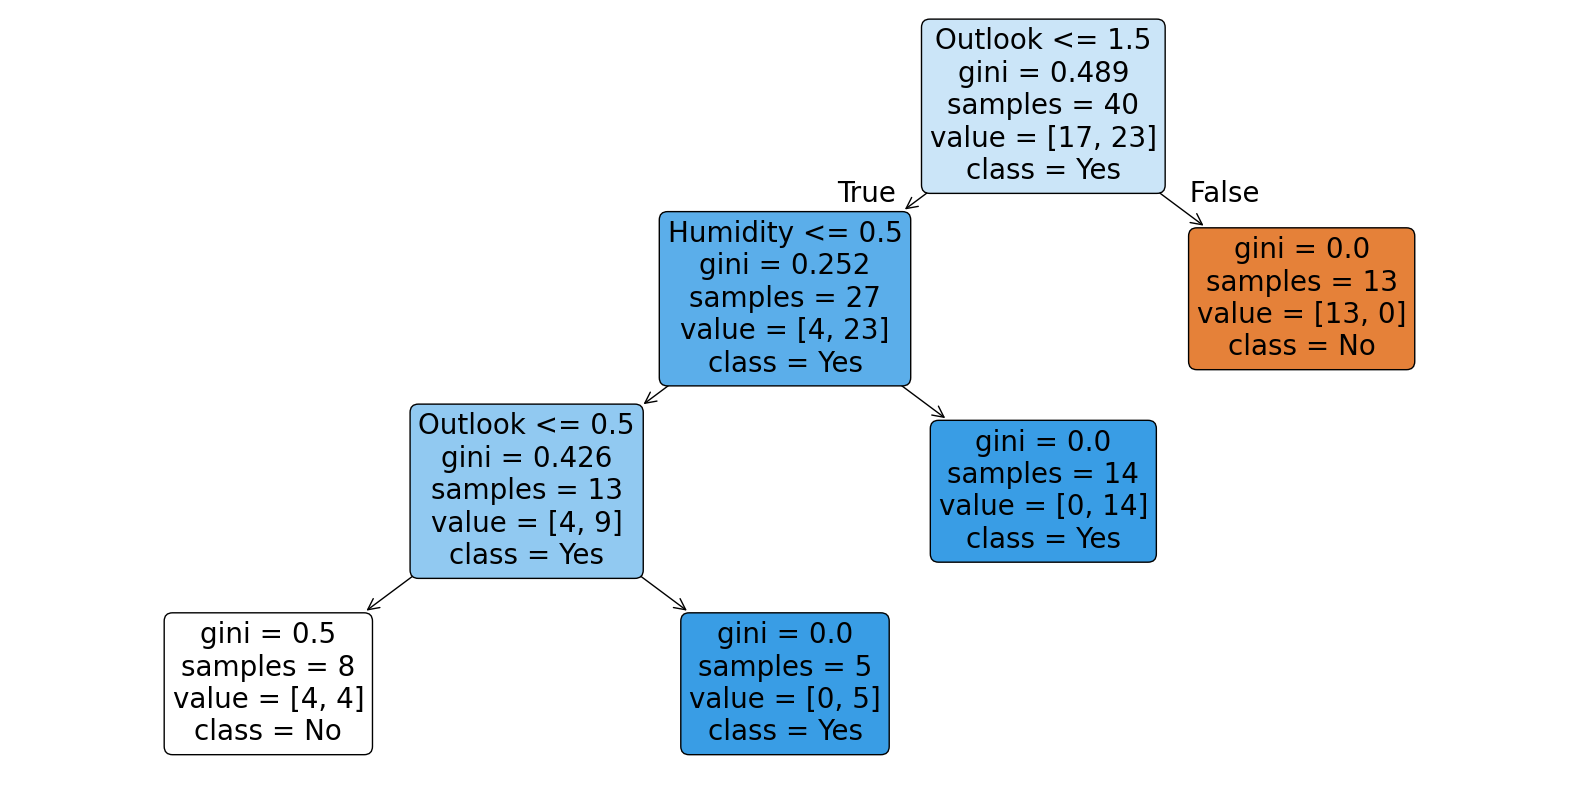

Model accuracy: 1.00


In [10]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import accuracy_score, classification_report
from sklearn import tree
import matplotlib.pyplot as plt
import numpy as np

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=25, stratify=y
)

# Create and train the decision tree
clf = DecisionTreeClassifier(max_depth=3, min_samples_leaf=5, random_state=42)
clf.fit(X_train, y_train)

# Define feature names from X_df (assuming X_df is available from your previous code)
feature_names = X_df.columns.tolist()  # ['Outlook', 'Temperature', 'Humidity', 'Wind']

# Visualize the tree with proper dimensions
plt.figure(figsize=(20, 10))
tree.plot_tree(clf,
               feature_names=feature_names[:clf.n_features_in_],
               class_names=['No', 'Yes'],
               filled=True,
               rounded=True,
               fontsize=20)
plt.show()

# Evaluate the model
y_pred = clf.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f"Model accuracy: {accuracy:.2f}")



### Dig deeper

In [12]:
# Display feature importances
feature_names = ['Outlook', 'Temperature', 'Humidity', 'Wind']  # Adjust to your actual feature names
if len(feature_names) != clf.n_features_in_:
    print(f"Warning: You have {clf.n_features_in_} features but only {len(feature_names)} feature names")
    # If one-hot encoded, you might need to expand feature names
    expanded_names = []
    for name in feature_names:
        expanded_names.extend([f"{name}_{i}" for i in range(X.shape[1] // len(feature_names))])
    feature_names = expanded_names[:clf.n_features_in_]

# Print feature importances
print("\nFeature importances:")
for feature, importance in zip(['Outlook', 'Temperature', 'Humidity', 'Wind'],
                              clf.feature_importances_):
    print(f"{feature}: {importance:.4f}")

# Cross-validation with appropriate fold count for 50 samples
print("\nCross-validation scores:")
kf = KFold(n_splits=5, shuffle=True, random_state=42)
cv_scores = []

for train_index, test_index in kf.split(X):
    X_fold_train, X_fold_test = [X[i] for i in train_index], [X[i] for i in test_index]
    y_fold_train, y_fold_test = [y[i] for i in train_index], [y[i] for i in test_index]

    fold_clf = DecisionTreeClassifier(max_depth=3, random_state=42)
    fold_clf.fit(X_fold_train, y_fold_train)

    fold_pred = fold_clf.predict(X_fold_test)
    fold_accuracy = accuracy_score(y_fold_test, fold_pred)
    cv_scores.append(fold_accuracy)
    print(f"Fold accuracy: {fold_accuracy:.2f}")

print(f"Average CV accuracy: {np.mean(cv_scores):.2f} ± {np.std(cv_scores):.2f}")



Feature importances:
Outlook: 0.9179
Temperature: 0.0000
Humidity: 0.0821
Wind: 0.0000

Cross-validation scores:
Fold accuracy: 1.00
Fold accuracy: 0.70
Fold accuracy: 0.90
Fold accuracy: 0.70
Fold accuracy: 1.00
Average CV accuracy: 0.86 ± 0.14
